# Data Preparation -- NYC Hospital Beds

In [37]:
#import libraries
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt

import folium  ## map rendering library

from bs4 import BeautifulSoup #for web scrapping

from fuzzywuzzy import fuzz

# import Kmeans from sklearn
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim

# import scipy.cluster.hierarchy
import scipy.cluster.hierarchy as sch

# aglomerative clustering
from sklearn.cluster import AgglomerativeClustering

# import DBSCAN
from sklearn.cluster import DBSCAN

import plotly.graph_objects as go

from sklearn import metrics

In [22]:
#load hospital beds dataset for the whole New York state gotten from HEALTH.DATA.NY.GOV

NY_beds = pd.read_csv('New_York_State_Statewide_COVID-19_Hospitalizations_and_Beds.csv')
NY_beds.head()

,As of Date,Facility PFI,Facility Name,DOH Region,Facility County,Facility Network,NY Forward Region,Patients Currently Hospitalized,Patients Admitted Due to COVID,Patients Admitted Not Due to COVID,...,Patients Age Less Than 1 Year,Patients Age 1 To 4 Years,Patients Age 5 to 19 Years,Patients Age 20 to 44 Years,Patients Age 45 to 54 Years,Patients Age 55 to 64 Years,Patients Age 65 to 74 Years,Patients Age 75 to 84 Years,Patients Age Greater Than 85 Years,Hospitalized Indicator
0,03/26/2020,1,ALBANY MEDICAL CENTER HOSPITAL,CAPITAL DISTRICT REGIONAL OFFICE,ALBANY,ALBANY MEDICAL CENTER,CAPITAL REGION,12.0,NaN,NaN,...,1.0,0.0,0.0,1.0,0.0,4.0,3.0,2.0,1.0,0
1,03/26/2020,5,ST PETERS HOSPITAL,CAPITAL DISTRICT REGIONAL OFFICE,ALBANY,ST. PETERS HEALTH PARTNERS,CAPITAL REGION,10.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0,1.0,0
2,03/26/2020,37,CUBA MEMORIAL HOSPITAL INC,WESTERN REGIONAL OFFICE,ALLEGANY,INDEPENDENT,WESTERN NEW YORK,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,03/26/2020,39,MEMORIAL HOSP OF WM F AND GERTRUDE F JONES AKA...,WESTERN REGIONAL OFFICE,ALLEGANY,UNIVERSITY OF ROCHESTER MEDICAL CENTER,WESTERN NEW YORK,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,03/26/2020,42,UNITED HEALTH SERVICES HOSPITALS INC - BINGHAM...,CENTRAL REGIONAL OFFICE,BROOME,"UNITED HEALTH SERVICES HOSPITALS, INC.",SOUTHERN TIER,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
#filter by New York city counties
county_list = ['BRONX', 'KINGS', 'QUEENS', 'RICHMOND', 'NEW YORK']
filtered_bed_df = NY_beds[NY_beds['Facility County'].isin(county_list)]

#check new dataframe
filtered_bed_df.columns

Index(['As of Date', 'Facility PFI', 'Facility Name', 'DOH Region',
       'Facility County', 'Facility Network', 'NY Forward Region',
       'Patients Currently Hospitalized', 'Patients Admitted Due to COVID',
       'Patients Admitted Not Due to COVID', 'Patients Newly Admitted',
       'Patients Positive After Admission', 'Patients Discharged',
       'Patients Currently in ICU', 'Patients Currently ICU Intubated',
       'Patients Expired', 'Cumulative COVID-19 Discharges to Date',
       'Cumulative COVID-19 Fatalities to Date', 'Total Staffed Beds',
       'Total Staffed Beds Currently Available', 'Total Staffed ICU Beds',
       'Total Staffed ICU Beds Currently Available',
       'Total Staffed Acute Care Beds',
       'Total Staffed Acute Care Beds Occupied', 'Total Staffed ICU Beds 1',
       'Total Staffed ICU Beds Currently Occupied',
       'Total New Admissions Reported', 'Patients Age Less Than 1 Year',
       'Patients Age 1 To 4 Years', 'Patients Age 5 to 19 Years',
  

In [4]:
#get only columns with bed information
##per data dictionary proovided, Total Staffed Acute Care Beds is the same as Total Staffed Beds -- nomenclature changed May 19, 2021
NYC_beds = filtered_bed_df[['Facility Name', 'Facility County', 'Total Staffed Beds', 'Total Staffed ICU Beds']]
                            

#check new dataframe
NYC_beds.head()

,Facility Name,Facility County,Total Staffed Beds,Total Staffed ICU Beds
136,JACOBI MEDICAL CENTER,BRONX,457.0,36.0
137,MONTEFIORE MEDICAL CENTER - WAKEFIELD HOSPITAL,BRONX,321.0,16.0
138,MONTEFIORE MEDICAL CENTER - HENRY AND LUCY MOS...,BRONX,816.0,60.0
139,LINCOLN MEDICAL AND MENTAL HEALTH CENTER,BRONX,362.0,45.0
140,SBH HEALTH SYSTEM,BRONX,322.0,16.0


In [5]:
NYC_beds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44451 entries, 136 to 151970
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Facility Name           44451 non-null  object 
 1   Facility County         44451 non-null  object 
 2   Total Staffed Beds      22063 non-null  float64
 3   Total Staffed ICU Beds  22059 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.7+ MB


In [6]:
#get facilities that have beds to treat in-patients
filter1= (NYC_beds['Total Staffed Beds'].notna())

NYC_hosp_beds= NYC_beds[filter1]

#check dataframe
NYC_hosp_beds.info()              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22063 entries, 136 to 83059
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Facility Name           22063 non-null  object 
 1   Facility County         22063 non-null  object 
 2   Total Staffed Beds      22063 non-null  float64
 3   Total Staffed ICU Beds  22059 non-null  float64
dtypes: float64(2), object(2)
memory usage: 861.8+ KB


In [7]:
NYC_hosp_beds.head()

,Facility Name,Facility County,Total Staffed Beds,Total Staffed ICU Beds
136,JACOBI MEDICAL CENTER,BRONX,457.0,36.0
137,MONTEFIORE MEDICAL CENTER - WAKEFIELD HOSPITAL,BRONX,321.0,16.0
138,MONTEFIORE MEDICAL CENTER - HENRY AND LUCY MOS...,BRONX,816.0,60.0
139,LINCOLN MEDICAL AND MENTAL HEALTH CENTER,BRONX,362.0,45.0
140,SBH HEALTH SYSTEM,BRONX,322.0,16.0


In [8]:
#convert Facility Name to title case
NYC_hosp_beds['Facility Name'] = NYC_hosp_beds['Facility Name'].str.title()

#check
NYC_hosp_beds.head()

/var/folders/s8/q17ghjw55fn1192037cmrkt00000gn/T/ipykernel_56155/4071318277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NYC_hosp_beds['Facility Name'] = NYC_hosp_beds['Facility Name'].str.title()


,Facility Name,Facility County,Total Staffed Beds,Total Staffed ICU Beds
136,Jacobi Medical Center,BRONX,457.0,36.0
137,Montefiore Medical Center - Wakefield Hospital,BRONX,321.0,16.0
138,Montefiore Medical Center - Henry And Lucy Mos...,BRONX,816.0,60.0
139,Lincoln Medical And Mental Health Center,BRONX,362.0,45.0
140,Sbh Health System,BRONX,322.0,16.0


In [9]:
#each entry is per date of report
#get median number of beds per facility
NYC_bed_df = (NYC_hosp_beds.groupby('Facility Name').median()).reset_index()

#check dataframe
NYC_bed_df

,Facility Name,Total Staffed Beds,Total Staffed ICU Beds
0,Bellevue Hospital Center,715.0,83.0
1,Bronxcare Hospital Center,437.0,78.0
2,Brookdale Hospital Medical Center,311.0,51.0
3,Brooklyn Hospital Center - Downtown Campus,399.0,45.0
4,Coney Island Hospital,376.0,48.0
5,Elmhurst Hospital Center,457.0,64.0
6,Flushing Hospital Medical Center,204.0,22.0
7,Harlem Hospital Center,229.0,27.0
8,Hospital For Special Surgery,171.0,4.0
9,Interfaith Medical Center,236.0,23.0


### Get hospital data for each neighbourhood based on latitude and longitude

In [10]:
#load hospital dataset from foursquare
NYC_fsq_hosp = pd.read_csv('NYC_foursquare_hosp.csv')

#check dataframe
NYC_fsq_hosp.head()

,ID,Name,Latitude,Longitude,Borough,Neighborhood
0,59832a7bfe37406ea7eb3a79,Statcare Urgent & Walk-In Medical Care (Bronx ...,40.870168,-73.828404,Bronx,Co-op City
1,50173409e4b0cfe38c43abf4,wellcare,40.874247,-73.837745,Bronx,Co-op City
2,568e86f5498ec6df53771448,CityMD Baychester Urgent Care - Bronx,40.866795,-73.827051,Bronx,Co-op City
3,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Fieldston
4,5158ddffe4b086af71ca90c7,The Mollie & Jack Zicklin Jewish Hospice Resid...,40.888478,-73.910047,Bronx,Riverdale


In [11]:
NYC_fsq_hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1174 non-null   object 
 1   Name          1174 non-null   object 
 2   Latitude      1174 non-null   float64
 3   Longitude     1174 non-null   float64
 4   Borough       1174 non-null   object 
 5   Neighborhood  1174 non-null   object 
dtypes: float64(2), object(4)
memory usage: 55.2+ KB


In [16]:
#combine hospital per neighbourhood data with hospital bed data

#define a function to match hospital name from Foursquare to hospital bed data

def match_hospital_beds_with_boro_neighborhood(bed_df, hospital_df):
    '''This function takes 2 dataframes as input
    bed_df: Dataframe of hospitals and the number of beds per hospital
    hospital_df: Dataframe of hospitals in the city with their Borough and neighorhood gotten from Foursquare
    Function Uses fuzzywuzzy to match hospital name from Foursquare dataset  to NYC bed dataframe'''
    
    data = []
    column_names = ["Facility Name", "Total Staffed ICU Beds","Total Staffed Beds"]
    boro_neig_column_names = ["Borough", "Neighborhood"]
    for i, row in bed_df.iterrows():
        data_per_hospital = None
        max_ratio = 0
        for x, hrow in hospital_df.iterrows():
            ratio = fuzz.token_sort_ratio(row["Facility Name"], hrow["Name"])
            if ratio > max_ratio:
                max_ratio = ratio
                data_per_hospital = [
                    row[column] for column in column_names] + \
                    [hrow[column] for column in boro_neig_column_names
                     ]
        if data_per_hospital:
            data.append(data_per_hospital)

    df = pd.DataFrame(data, columns=column_names+boro_neig_column_names)
    
    #convert dataframe to csv
    df.to_csv('new_hospital_data.csv',index = False)
    
    return df

In [17]:
NYC_hosp_bed = match_hospital_beds_with_boro_neighborhood(NYC_bed_df, NYC_fsq_hosp)

In [18]:
NYC_hosp_bed.head()

,Facility Name,Total Staffed ICU Beds,Total Staffed Beds,Borough,Neighborhood
0,Bellevue Hospital Center,83.0,715.0,Manhattan,Murray Hill
1,Bronxcare Hospital Center,78.0,437.0,Bronx,Morrisania
2,Brookdale Hospital Medical Center,51.0,311.0,Brooklyn,Brownsville
3,Brooklyn Hospital Center - Downtown Campus,45.0,399.0,Brooklyn,Fort Greene
4,Coney Island Hospital,48.0,376.0,Brooklyn,Gravesend


In [19]:
NYC_hosp_bed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Facility Name           59 non-null     object 
 1   Total Staffed ICU Beds  59 non-null     float64
 2   Total Staffed Beds      59 non-null     float64
 3   Borough                 59 non-null     object 
 4   Neighborhood            59 non-null     object 
dtypes: float64(2), object(3)
memory usage: 2.4+ KB


In [20]:
#compute Total staffed beds and Total Staffed ICU bed per neighbourhood
NYC_hosp_bed = NYC_hosp_bed.groupby(['Borough', 'Neighborhood']).agg({'Total Staffed ICU Beds': 'sum', 'Total Staffed Beds': 'sum'})

NYC_hosp_bed

Total Staffed ICU Beds  \
Borough       Neighborhood                                        
Bronx         East Tremont                                 27.0   
              Melrose                                     119.0   
              Morris Heights                               38.0   
              Morrisania                                   78.0   
              Norwood                                     169.0   
              Parkchester                                   0.0   
              Pelham Parkway                                0.0   
              Woodlawn                                     25.0   
Brooklyn      Borough Park                                 80.0   
              Brownsville                                  71.0   
              Bushwick                                     24.0   
              Carroll Gardens                              99.0   
              Crown Heights                                23.0   
              Fort Greene                                  64.0   
              Gravesend                                    48.0   
              Prospect Lefferts Gardens                    81.0   
              Rugby                                        20.0   
              Sunset Park                                  42.0   
              Windsor Terrace                              51.0   
Manhattan     Chelsea                                       0.0   
              Chinatown                                    22.0   
              East Harlem                                 295.0   
              East Village                                 27.5   
              Inwood                                       14.0   
              Morningside Heights                          48.0   
              Murray Hill                                 291.0   
              Turtle Bay                                  134.0   
              Upper East Side                              72.0   
              Upper West Side                              77.0   
              Yorkville                                   214.0   
Queens        Briarwood                                   170.0   
              Far Rockaway                                 34.0   
              Forest Hills                                 23.0   
              Glen Oaks                                    98.0   
              Jackson Heights                              64.0   
Staten Island South Beach                                 116.0   
              West Brighton                                31.0   

                                         Total Staffed Beds  
Borough       Neighborhood                                   
Bronx         East Tremont                            229.0  
              Melrose                                1040.0  
              Morris Heights                          394.0  
              Morrisania                              437.0  
              Norwood                                1472.0  
              Parkchester                               0.0  
              Pelham Parkway                           72.0  
              Woodlawn                                330.0  
Brooklyn      Borough Park                            748.0  
              Brownsville                             411.0  
              Bushwick                                223.0  
              Carroll Gardens                         626.0  
              Crown Heights                           236.0  
              Fort Greene                             561.0  
              Gravesend                               376.0  
              Prospect Lefferts Gardens               934.0  
              Rugby                                   231.5  
              Sunset Park                             279.0  
              Windsor Terrace                         577.0  
Manhattan     Chelsea                                  26.0  
              Chinatown                               152.0  
 

In [28]:
NYC_hosp_bed.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37 entries, ('Bronx', 'East Tremont') to ('Staten Island', 'West Brighton')
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Staffed ICU Beds  37 non-null     float64
 1   Total Staffed Beds      37 non-null     float64
dtypes: float64(2)
memory usage: 1.1+ KB


In [21]:
#load neighbourhood dataset with latitude, logitude and population
NYC_data = pd.read_csv('NYC_neighbourhood.csv')

#check
NYC_data

,Neighbourhood,borough,longitude,latitude,Population,ZIP Codes
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470"
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471"
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463
...,...,...,...,...,...,...
301,Sandy Ground,Staten Island,-74.217766,40.541140,33883.0,10309
302,Roxbury,Queens,-73.892138,40.567376,2170.0,11697
303,Lighthouse Hill,Staten Island,-74.137927,40.576506,8849.0,10306
304,Hammels,Queens,-73.805530,40.587338,13029.0,11693


In [25]:
#rename borough column to Borough and Neighbourhood to Neighborhood for merging
NYC_data.rename(columns={'borough': 'Borough', 'Neighbourhood': 'Neighborhood'}, inplace=True)

#check
NYC_data

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470"
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471"
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463
...,...,...,...,...,...,...
301,Sandy Ground,Staten Island,-74.217766,40.541140,33883.0,10309
302,Roxbury,Queens,-73.892138,40.567376,2170.0,11697
303,Lighthouse Hill,Staten Island,-74.137927,40.576506,8849.0,10306
304,Hammels,Queens,-73.805530,40.587338,13029.0,11693


In [29]:
#merge NYC_data with NYC_hosp_bed

hosp_final_df = pd.merge(NYC_data, NYC_hosp_bed, how = 'left', on=['Borough', 'Neighborhood'])

#check
hosp_final_df.head()

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",NaN,NaN
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,NaN,NaN
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,NaN,NaN
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",NaN,NaN
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,NaN,NaN


In [30]:
hosp_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            306 non-null    object 
 1   Borough                 306 non-null    object 
 2   longitude               306 non-null    float64
 3   latitude                306 non-null    float64
 4   Population              306 non-null    float64
 5   ZIP Codes               306 non-null    object 
 6   Total Staffed ICU Beds  37 non-null     float64
 7   Total Staffed Beds      37 non-null     float64
dtypes: float64(5), object(3)
memory usage: 21.5+ KB


In [31]:
#fill missing values with zeros as these neighborhoods don't have NYS health dept COVID desginated (acute) hospitals

hosp_final_df.fillna(0, inplace=True)

In [32]:
hosp_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            306 non-null    object 
 1   Borough                 306 non-null    object 
 2   longitude               306 non-null    float64
 3   latitude                306 non-null    float64
 4   Population              306 non-null    float64
 5   ZIP Codes               306 non-null    object 
 6   Total Staffed ICU Beds  306 non-null    float64
 7   Total Staffed Beds      306 non-null    float64
dtypes: float64(5), object(3)
memory usage: 21.5+ KB


In [33]:
#compute number of beds per 1,000 people
hosp_final_df['Beds per 1,000 people'] = (hosp_final_df['Total Staffed Beds']/hosp_final_df['Population']) *1000

hosp_final_df['ICU Beds per 1,000 people'] = (hosp_final_df['Total Staffed ICU Beds']/hosp_final_df['Population']) *1000

#check
hosp_final_df.head(15)

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people"
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",0.0,0.0,0.000000,0.000000
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,0.0,0.0,0.000000,0.000000
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,0.0,0.0,0.000000,0.000000
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",0.0,0.0,0.000000,0.000000
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,0.0,0.0,0.000000,0.000000
5,Marble Hill,Manhattan,-73.910660,40.876551,9481.0,10463,0.0,0.0,0.000000,0.000000
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,169.0,1472.0,36.351064,4.173458
7,Williamsbridge,Bronx,-73.857446,40.881039,61321.0,"10466, 10467, 10469",0.0,0.0,0.000000,0.000000
8,Baychester,Bronx,-73.835798,40.866858,63345.0,10469,0.0,0.0,0.000000,0.000000
9,Pelham Parkway,Bronx,-73.854756,40.857413,30073.0,"10461, 10462",0.0,72.0,2.394174,0.000000


In [34]:
#for clustering drop Neighborhood, Borough, longitude, latitude, Population, ZIP Codes, Total Staffed ICU Beds, Total Staffed Beds

bed_cluster_df = hosp_final_df.drop(['Neighborhood', 'Borough', 'longitude', 'latitude', 'Population', 'ZIP Codes', 
                                    'Total Staffed ICU Beds', 'Total Staffed Beds'], axis = 1)

#check
bed_cluster_df.head()

,"Beds per 1,000 people","ICU Beds per 1,000 people"
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [35]:
bed_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 305
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Beds per 1,000 people      306 non-null    float64
 1   ICU Beds per 1,000 people  306 non-null    float64
dtypes: float64(2)
memory usage: 7.2 KB


## Use kMeans

In [38]:
#standardize using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bed_cluster_df)

In [39]:
###Elbow Rule --Used to determine k - number of clusters -- aim for small inertia/distortion

#define function to calculate the distortion(inertia) for multiple k values and plot the results
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)
        
    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

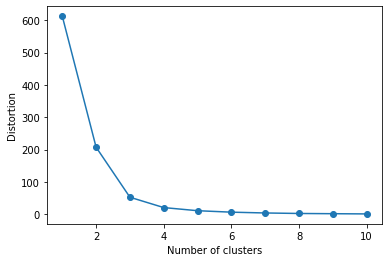

In [40]:
# elbow rule
plot_distortion(scaled_data,max_clusters=10)

In [42]:
##K-Means Clustering

km = KMeans(n_clusters=3, # how many clusters from elbow rule
            n_init=10, # how many initial runs
            random_state=0) #For reproducibility

#fit and predict the scaled data
y_km = km.fit_predict(scaled_data)

In [43]:
#get the cluster each neighborhood belongs to
hosp_final_df['cluster'] = y_km

#check dataframe
hosp_final_df.head(10)

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people",cluster
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",0.0,0.0,0.000000,0.000000,0
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,0.0,0.0,0.000000,0.000000,0
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,0.0,0.0,0.000000,0.000000,0
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",0.0,0.0,0.000000,0.000000,0
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,0.0,0.0,0.000000,0.000000,0
5,Marble Hill,Manhattan,-73.910660,40.876551,9481.0,10463,0.0,0.0,0.000000,0.000000,0
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,169.0,1472.0,36.351064,4.173458,2
7,Williamsbridge,Bronx,-73.857446,40.881039,61321.0,"10466, 10467, 10469",0.0,0.0,0.000000,0.000000,0
8,Baychester,Bronx,-73.835798,40.866858,63345.0,10469,0.0,0.0,0.000000,0.000000,0
9,Pelham Parkway,Bronx,-73.854756,40.857413,30073.0,"10461, 10462",0.0,72.0,2.394174,0.000000,0


In [44]:
#check cluster 1
hosp_final_df[hosp_final_df['cluster'] == 1]

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people",cluster
75,Murray Hill,Manhattan,-73.978332,40.748303,10864.0,"10016, 10017",291.0,2231.0,205.357143,26.785714,1


In [45]:
#check cluster 2
hosp_final_df[hosp_final_df['cluster'] == 2]

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people",cluster
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,169.0,1472.0,36.351064,4.173458,2
16,Melrose,Bronx,-73.909422,40.819754,24913.0,"10451, 10455, 10456",119.0,1040.0,41.745274,4.776623,2
21,Morrisania,Bronx,-73.901506,40.823592,16863.0,"10456, 10459",78.0,437.0,25.914725,4.625511,2
42,Windsor Terrace,Brooklyn,-73.980073,40.656946,20988.0,"11215, 11218",51.0,577.0,27.491900,2.429960,2
48,Carroll Gardens,Brooklyn,-73.994654,40.680540,12853.0,11231,99.0,626.0,48.704583,7.702482,2
71,Yorkville,Manhattan,-73.947118,40.775930,35221.0,"10028, 10075, 10128",214.0,1216.0,34.524857,6.075921,2
102,Glen Oaks,Queens,-73.715481,40.749441,29506.0,"11004, 11005, 11040, 11426",98.0,864.0,29.282180,3.321358,2
105,Briarwood,Queens,-73.811748,40.710935,53877.0,11435,170.0,1496.0,27.766951,3.155335,2
129,South Beach,Staten Island,-74.079553,40.580247,8575.0,10305,116.0,666.0,77.667638,13.527697,2
141,Turtle Bay,Manhattan,-73.967708,40.752042,24856.0,"10017, 10022",134.0,839.0,33.754425,5.391052,2


In [85]:
#visualize neighborhood clusters

#define a function to visualize neighborhood cluster on map

def neighborhood_bed_cluster_viz(num_clusters, df, colours):

    '''This function takes an input of the num of clusters with maximum of 5 clusters, 
    a dataframe and a list of colours based on cluster interpretation and outputs a map of the neighbourhood with each circle 
    representing a neighbourhood and the colour representing the cluster the neighbourhood belongs to'''
   
    #get latitude, longitude of New York city
    latitude = 40.7127281
    longitude  = -74.0060152

    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the clusters
    num_clusters = num_clusters
    colours = colours
    #colours = ['red', 'green','yellow' , 'purple', 'pink']
    
    # add markers to the map
    markers_colors = []
    for lat, lon, bor, nei, cluster, beds, ICU in zip(
        df['latitude'], df['longitude'], df['Borough'], df['Neighborhood'], 
        df['cluster'], df['Beds per 1,000 people'], df['ICU Beds per 1,000 people']):

            label = folium.Popup(('Cluster' + " " + str(cluster)+': ' + str(bor) + "-" + str(nei) + " "+
                                 str(round(beds, 2)) + " " + "Beds per 1,000 people" + " " + str(round(ICU, 2)) + " " + "ICU Beds per 1,000 people"),
                                 parse_html=True)
            folium.CircleMarker([lat, lon],
                radius=5,
                popup=label,
                color=colours[cluster],
                fill=True,
                fill_color=colours[cluster],
                fill_opacity=0.7).add_to(map_clusters)
            
    return map_clusters

In [87]:
#visualize neighborhood cluster on beds per 1000 people on a graph
neighborhood_bed_cluster_viz(3, hosp_final_df, ['red', 'green', 'yellow'])

In [49]:
##evaluate kmeans segmentation using silhoutte score
labels = km.labels_
metrics.silhouette_score(scaled_data, labels, metric='euclidean')

0.9492152016819925

In [54]:
#To visualize actual hospital spread across the city, we will remove neighborhoods with no acute care hospitals


hosp_cluster_df = hosp_final_df.drop(['Neighborhood', 'Borough', 'longitude', 'latitude', 'Population', 'ZIP Codes', 
                                    'Total Staffed ICU Beds', 'Total Staffed Beds', 'cluster'], axis = 1)

#check
hosp_cluster_df.head()

,"Beds per 1,000 people","ICU Beds per 1,000 people"
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [55]:
#drop rows with zero beds per 1,000 people
hosp_cluster_df.drop(hosp_cluster_df[hosp_cluster_df['Beds per 1,000 people'] == 0.0].index, inplace=True)

#check
hosp_cluster_df.head()

,"Beds per 1,000 people","ICU Beds per 1,000 people"
6,36.351064,4.173458
9,2.394174,0.000000
12,10.712635,1.033198
14,5.273703,0.621790
16,41.745274,4.776623


In [56]:
#standardize using StandardScaler
scaler = StandardScaler()
new_scaled_data = scaler.fit_transform(hosp_cluster_df)

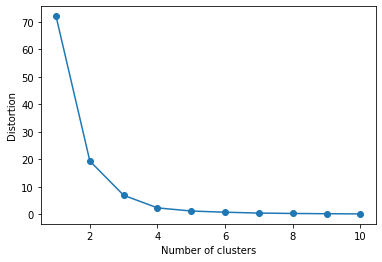

In [57]:
# elbow rule
plot_distortion(new_scaled_data,max_clusters=10)

In [58]:
##K-Means Clustering

km1 = KMeans(n_clusters=2, # how many clusters from elbow rule
            n_init=10, # how many initial runs
            random_state=0) #For reproducibility

#fit and predict the scaled data
y_km1 = km1.fit_predict(new_scaled_data)

In [60]:
#get dataframe for only acute hospital locations
#drop rows with zero beds per 1,000 people

hosp_viz_df = hosp_final_df.drop(hosp_final_df[hosp_final_df['Beds per 1,000 people'] == 0.0].index)

#drop column 'clusters'

hosp_viz_df.drop(['cluster'], axis=1, inplace=True)

#check
hosp_viz_df.head()

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people"
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,169.0,1472.0,36.351064,4.173458
9,Pelham Parkway,Bronx,-73.854756,40.857413,30073.0,"10461, 10462",0.0,72.0,2.394174,0.000000
12,Morris Heights,Bronx,-73.919672,40.847898,36779.0,"10452, 10453",38.0,394.0,10.712635,1.033198
14,East Tremont,Bronx,-73.887356,40.842696,43423.0,"10457, 10460",27.0,229.0,5.273703,0.621790
16,Melrose,Bronx,-73.909422,40.819754,24913.0,"10451, 10455, 10456",119.0,1040.0,41.745274,4.776623


In [61]:
#get cluster that each neighborhood belongs to
hosp_viz_df['cluster'] = y_km1

In [63]:
hosp_viz_df.head()

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people",cluster
6,Norwood,Bronx,-73.879391,40.877224,40494.0,10467,169.0,1472.0,36.351064,4.173458,0
9,Pelham Parkway,Bronx,-73.854756,40.857413,30073.0,"10461, 10462",0.0,72.0,2.394174,0.000000,0
12,Morris Heights,Bronx,-73.919672,40.847898,36779.0,"10452, 10453",38.0,394.0,10.712635,1.033198,0
14,East Tremont,Bronx,-73.887356,40.842696,43423.0,"10457, 10460",27.0,229.0,5.273703,0.621790,0
16,Melrose,Bronx,-73.909422,40.819754,24913.0,"10451, 10455, 10456",119.0,1040.0,41.745274,4.776623,0


In [64]:
#check cluster 1
hosp_viz_df[hosp_viz_df['cluster'] == 1]

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people",cluster
75,Murray Hill,Manhattan,-73.978332,40.748303,10864.0,"10016, 10017",291.0,2231.0,205.357143,26.785714,1


In [88]:
#visualize hospital beds on a map
neighborhood_bed_cluster_viz(2, hosp_viz_df, ['yellow', 'green'])

In [67]:
##evaluate kmeans segmentation using silhoutte score
labels = km1.labels_
metrics.silhouette_score(new_scaled_data, labels, metric='euclidean')

0.8635045742762943

### Task
Use different data sources and APIs to collect information about the neigborhoods that can be used for segmentation.

### Task

Visualize the neigborhoods in the graph.

In [69]:
hospital_cleaned_df = hosp_final_df.drop('cluster', axis = 1)

In [70]:
hospital_cleaned_df.head()

,Neighborhood,Borough,longitude,latitude,Population,ZIP Codes,Total Staffed ICU Beds,Total Staffed Beds,"Beds per 1,000 people","ICU Beds per 1,000 people"
0,Wakefield,Bronx,-73.847201,40.894705,29158.0,"10466, 10470",0.0,0.0,0.0,0.0
1,Co-op City,Bronx,-73.829939,40.874294,43752.0,10475,0.0,0.0,0.0,0.0
2,Fieldston,Bronx,-73.905643,40.895437,3292.0,10471,0.0,0.0,0.0,0.0
3,Riverdale,Bronx,-73.912585,40.890834,48049.0,"10463, 10471",0.0,0.0,0.0,0.0
4,Kingsbridge,Bronx,-73.902818,40.881687,10669.0,10463,0.0,0.0,0.0,0.0


In [89]:
#convert to csv
hospital_cleaned_df.to_csv('hospital_cleaned_df.csv', index=False)

In [80]:
#define function to plot bar charts of the data
def bar_chart(data, group, field, title, x_label, y_label, calculation):
    """This function plots bar charts given 7 inputs:
    data: the dataframe to be plotted
    group: the column (in apostrophe) in the dataframe to groupby
    field: the column (in apostrophe) in the dataframe to perform an operation (sum or count) on
    title: the title of the bar chart (in apostrophe)
    x_label: label of the x-axis (in apostrophe)
    y_label: label of the y_axis (in apostrophe)
    calculation: sum or count operation (in apostrophe) to be computed on the field column provided
    """
    plt.figure(figsize=(9, 5))
    plt.title(title)
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    
    if calculation == "count":
        data.groupby(group)[field].count().plot(kind='bar')
    
    if calculation == "sum":
        data.groupby(group)[field].sum().plot(kind='bar')

    plt.show()

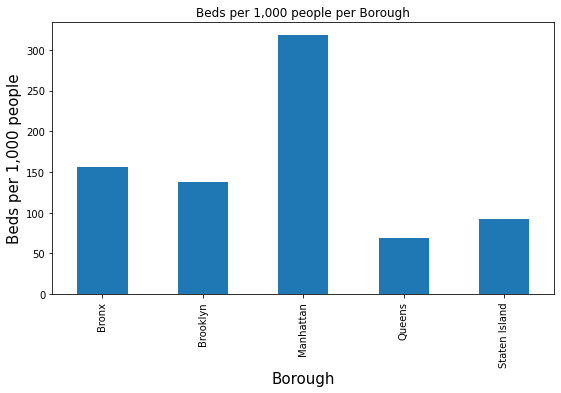

In [75]:
bar_chart(hospital_cleaned_df, 'Borough', 'Beds per 1,000 people', 'Beds per 1,000 people per Borough', 'Borough', 'Beds per 1,000 people', 'sum')

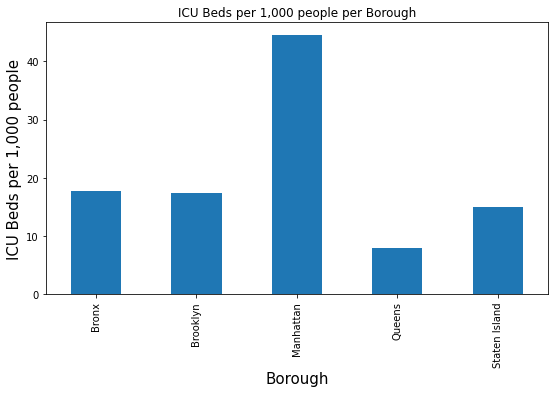

In [76]:
bar_chart(hospital_cleaned_df, 'Borough', 'ICU Beds per 1,000 people', 'ICU Beds per 1,000 people per Borough', 'Borough', 'ICU Beds per 1,000 people', 'sum')